# Fake News Classifier with RCNN (Model 2)

In [1]:
import io
import random
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image  as mpimg

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
data = pd.read_csv('/raid/tft-data/data-covid/covid_combined.csv')

# converting labels from strings to ints
data["label"].replace({"Real": 1, "Fake": 0}, inplace=True)
data = data.fillna(' ')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17894 entries, 0 to 17893
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   17894 non-null  object
 1   label   17894 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 279.7+ KB


In [3]:
# Tokenizing Data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['title'])
word_index = tokenizer.word_index
vocab_size=len(word_index)
max_seq_length = 8

sequences = tokenizer.texts_to_sequences(data['title'])
padded = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

In [4]:
# Compartmentalizing data into training set and testing set
X = padded
y = data['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Defining and Training the Model 

In [5]:
'''
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 64, input_length=512, trainable=False),
    tf.keras.layers.Conv1D(256, 5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(512, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(768, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(1, activation='sigmoid')

])
'''


model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, 128, input_length=8, trainable=False),
    tf.keras.layers.Conv1D(256, 5, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(512, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(768, 1, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dropout(0.1),  
    tf.keras.layers.Dense(1, activation='sigmoid')

])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_data=(X_valid, y_valid))

print("Training Complete")

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 8, 128)            1514112   
_________________________________________________________________
conv1d (Conv1D)              (None, 8, 256)            164096    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4, 256)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 4, 512)            131584    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 512)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 768)            393984    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 768)            0

## Visualizing the Results

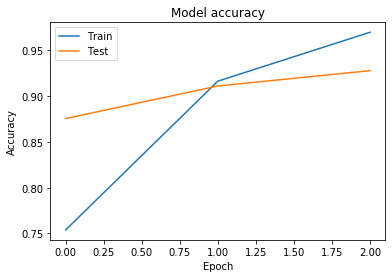

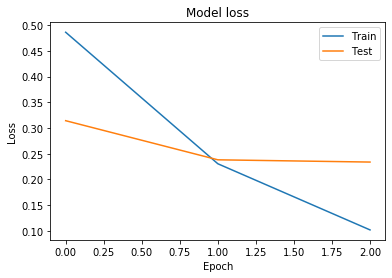

In [6]:
# Repeat for the Second Model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Confusion Matrix 

In [7]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

/home/CAMPUS/jrab2017/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


<Figure size 432x288 with 0 Axes>

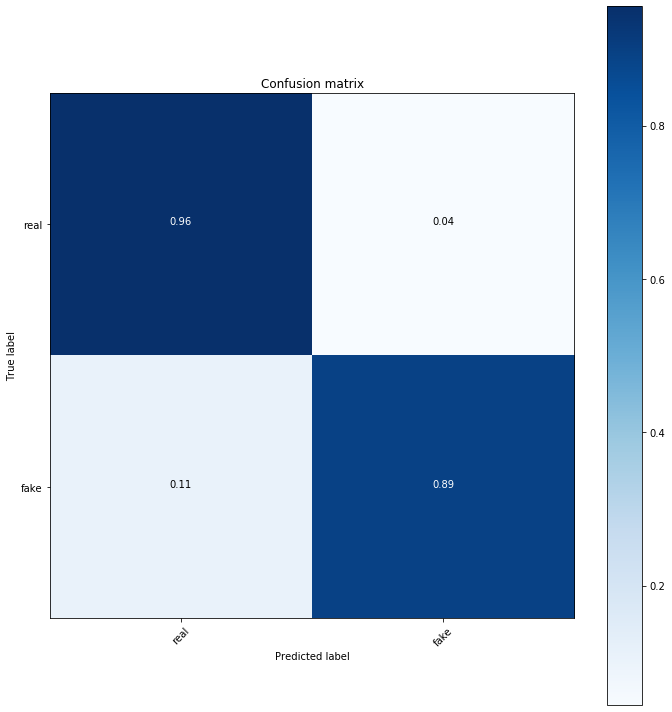

[[1305   61]
 [ 120 1019]]


In [8]:
class_names = ['real', 'fake']
# compute confusion matrix
y_pred = model.predict_classes(X_valid)
cnf_matrix = confusion_matrix(y_valid, y_pred)
np.set_printoptions(precision=2)

# plot confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

print(cnf_matrix)

### Validation Data Results

In [9]:
print('Classification Report:')
print(classification_report(y_valid, y_pred, digits=4))

Classification Report:
              precision    recall  f1-score   support

           0     0.9158    0.9553    0.9351      1366
           1     0.9435    0.8946    0.9184      1139

    accuracy                         0.9277      2505
   macro avg     0.9297    0.9250    0.9268      2505
weighted avg     0.9284    0.9277    0.9275      2505



### Testing Data Results

In [10]:
print('Testing Results:')
y_pred_test = model.predict_classes(X_test)
print(classification_report(y_test, y_pred_test))

Testing Results:
              precision    recall  f1-score   support

           0       0.91      0.95      0.93      2961
           1       0.94      0.88      0.91      2408

    accuracy                           0.92      5369
   macro avg       0.92      0.91      0.92      5369
weighted avg       0.92      0.92      0.92      5369

